In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, max_error
from sklearn.model_selection import train_test_split
import pygad
import scipy.stats

In [2]:
# Importar el excel
database = pd.read_excel(r'C:\Users\matia\Documents\UPA\TIE\Base de datos.xlsx')

# Separar columnas de composición y propiedades
composicion = ['C [%]', 'H [%]', 'N [%]', 'S [%]', 'O [%]']
propiedades = ['Viscosity [mm2/s]', 'HHV [MJ/kg]', 'LHV [MJ/kg]', 'pH']

In [3]:
# Implementar Algoritmo Genetico usando PyGAD
class GeneticAlgorithmModel:
    def __init__(self, generations=1000, population_size=20):
        self.generations = generations
        self.population_size = population_size
        self.best_model = None

    def fit(self, X, y):
        def fitness_func(solution, solution_idx):
            # Calcular predicciones
            y_pred = np.dot(X, solution)
            return -np.mean((y - y_pred)**2)  # Minimizar el error cuadrático medio

        num_genes = X.shape[1]
        ga_instance = pygad.GA(
            num_generations=self.generations,
            num_parents_mating=5,
            fitness_func=fitness_func,
            sol_per_pop=self.population_size,
            num_genes=num_genes,
            init_range_low=-1.0,
            init_range_high=1.0,
            mutation_percent_genes=10,
            mutation_num_genes=1,
            mutation_type='random'
        )
        ga_instance.run()
        self.best_model = ga_instance.best_solution()[0]

    def predict(self, X):
        return np.dot(X, self.best_model)

In [4]:
# Definir pipelines
pipelines = {
    'Multiple Linear Regression': Pipeline([
        ('scaler', StandardScaler()), 
        ('model', LinearRegression())
    ]),
    'Polynomial Regression (Deg 2)': Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2)),
        ('model', LinearRegression())
    ]),
    'Polynomial Regression (Deg 3)': Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=3)),
        ('model', LinearRegression())
    ]),
    'Bayesian Ridge': Pipeline([
        ('scaler', StandardScaler()), 
        ('model', BayesianRidge())
    ]),
    'Gaussian Process Regression': Pipeline([
        ('scaler', StandardScaler()), 
        ('model', GaussianProcessRegressor())
    ]),
    'Random Forest Regression': Pipeline([
        ('model', RandomForestRegressor(random_state=42))
    ]),
    'Genetic Algorithm': GeneticAlgorithmModel()
}

,Model,R^2 Train,R^2 Test,MAD,Max Dev
0,Multiple Linear Regression,0.973,-2595.681,120.456,341.541
1,Polynomial Regression (Deg 2),1.000,-341.509,64.051,76.675
2,Polynomial Regression (Deg 3),1.000,-281.913,51.773,84.991
3,Bayesian Ridge,0.951,-202.150,38.272,75.418
4,Gaussian Process Regression,1.000,-69.627,25.003,45.375
5,Random Forest Regression,0.970,-183.559,38.364,72.705
6,Genetic Algorithm,0.947,-152.184,32.170,68.067


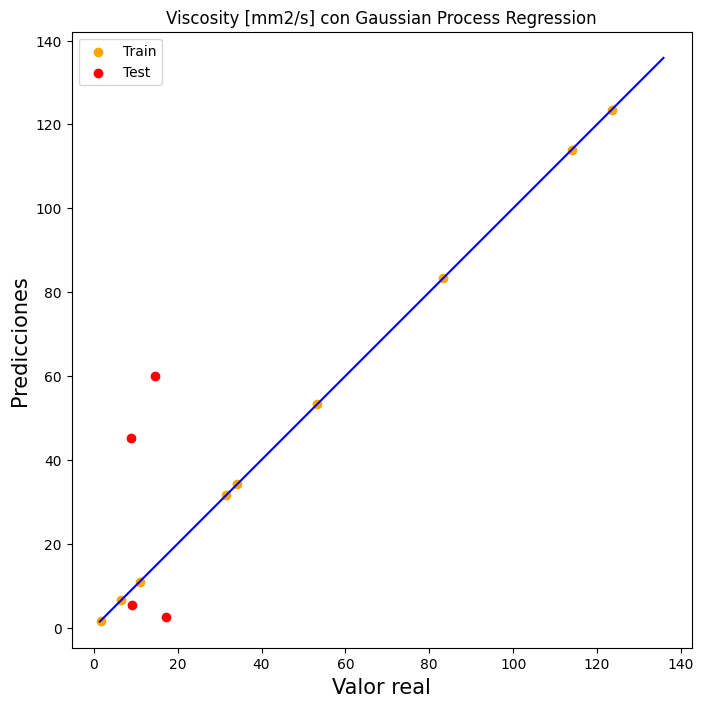

,Model,R^2 Train,R^2 Test,MAD,Max Dev
0,Multiple Linear Regression,0.747,0.717,1.529,3.820
1,Polynomial Regression (Deg 2),1.000,0.548,1.857,5.354
2,Polynomial Regression (Deg 3),1.000,0.370,2.308,5.731
3,Bayesian Ridge,0.720,0.716,1.567,3.943
4,Gaussian Process Regression,1.000,0.549,1.418,6.205
5,Random Forest Regression,0.903,0.734,1.756,2.874
6,Genetic Algorithm,0.540,0.548,1.880,4.508


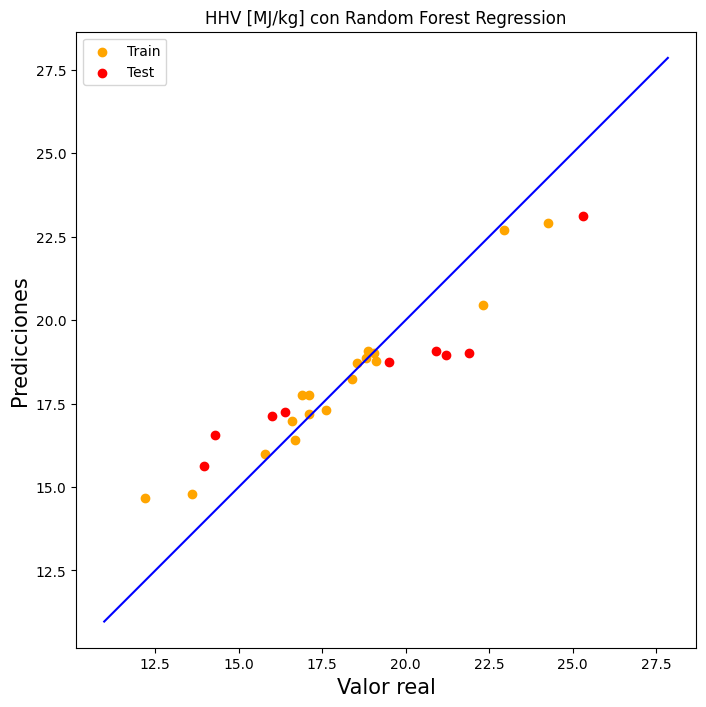

,Model,R^2 Train,R^2 Test,MAD,Max Dev
0,Multiple Linear Regression,1.000,-0.381,1.533,4.574
1,Polynomial Regression (Deg 2),1.000,0.918,0.629,0.780
2,Polynomial Regression (Deg 3),1.000,0.944,0.468,0.789
3,Bayesian Ridge,0.991,0.991,0.183,0.321
4,Gaussian Process Regression,1.000,-2.923,3.325,7.295
5,Random Forest Regression,0.909,0.785,0.985,1.421
6,Genetic Algorithm,0.985,0.917,0.436,1.116


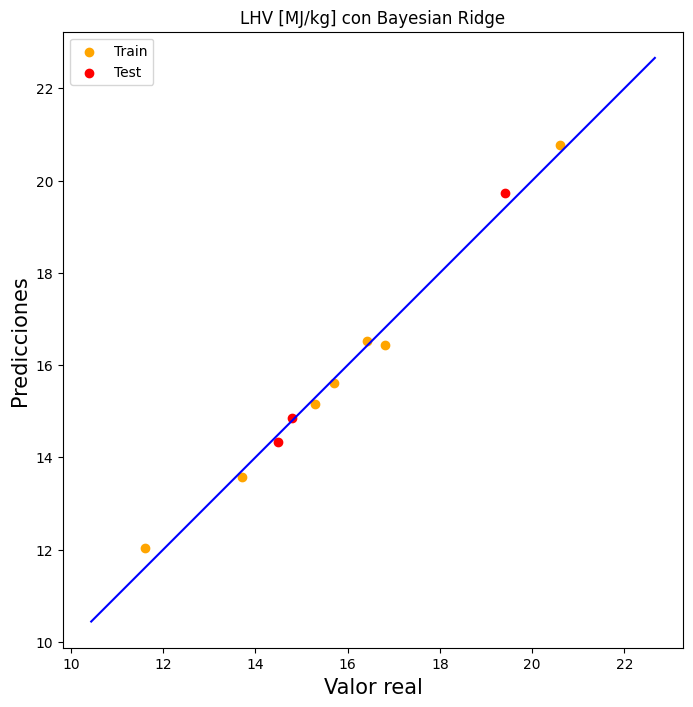

,Model,R^2 Train,R^2 Test,MAD,Max Dev
0,Multiple Linear Regression,0.688,-12.127,1.927,6.246
1,Polynomial Regression (Deg 2),1.000,-147.797,4.240,23.247
2,Polynomial Regression (Deg 3),1.000,-232.770,5.086,29.178
3,Bayesian Ridge,0.006,0.018,0.618,1.351
4,Gaussian Process Regression,1.000,-4.949,1.123,4.410
5,Random Forest Regression,0.798,0.737,0.383,0.575
6,Genetic Algorithm,-0.131,-5.164,1.153,4.598


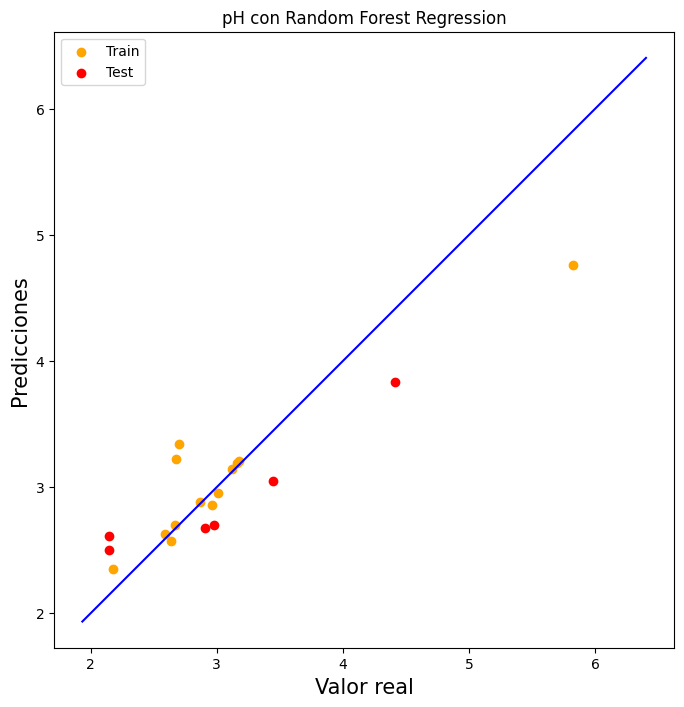

,Componente,Viscosity [mm2/s],HHV [MJ/kg],LHV [MJ/kg],pH
0,C,0.778527,0.737805,0.949921,0.476993
1,H,-0.507988,-0.287610,-0.704852,0.176854
2,N,-0.571678,-0.022367,-0.000899,0.371188
3,S,-0.458975,-0.053196,-0.300555,0.521217
4,O,-0.656830,-0.069894,-0.916767,0.322393


In [7]:
corr_df = pd.DataFrame({'Componente': ['C', 'H', 'N', 'S', 'O']})

for propiedad in propiedades:

    database_drop = database.dropna(subset=[propiedad])
    X = database_drop[composicion]
    y = database_drop[propiedad]

    # Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


    # Evaluación de modelos
    results = []

    for name, pipeline in pipelines.items():
        if name == 'Genetic Algorithm Regressor':
            # Ajustar el modelo genético
            pipeline.fit(X_train, y_train)
            y_pred_train = pipeline.predict(X_train)
            y_pred_test = pipeline.predict(X_test)
        else:
            # Ajustar otros modelos
            pipeline.fit(X_train, y_train)
            y_pred_train = pipeline.predict(X_train)
            y_pred_test = pipeline.predict(X_test)
        
        # Calcular métricas
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)
        mae = mean_absolute_error(y_test, y_pred_test)
        max_dev = max_error(y_test, y_pred_test)
        
        # Guardar resultados
        results.append({
            'Model': name,
            'R^2 Train': round(r2_train, 3),
            'R^2 Test': round(r2_test, 3),
            'MAD': round(mae, 3),
            'Max Dev': round(max_dev, 3)
        })

    # Mostrar resultados en formato tabla
    results_df = pd.DataFrame(results)
    display(results_df)

    # Selección de mejor algoritmo para el gráfico
    best_algo_idx = results_df['R^2 Test'].idxmax()
    best_algo = results_df.at[best_algo_idx, 'Model']

    pipeline = pipelines.get(best_algo)

    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    # Generacion de graficos
    plt.figure(figsize=(8,8))
    plt.scatter(y_train, y_pred_train, c='orange', label='Train')
    plt.scatter(y_test, y_pred_test, c='red', label='Test')

    p1 = max(max(y_pred_test), max(y_test), max(y)) * 1.1
    p2 = min(min(y_pred_test), min(y_test), min(y)) * 0.9
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('Valor real', fontsize=15)
    plt.ylabel('Predicciones', fontsize=15)
    plt.title(str(propiedad + ' con ' + best_algo))
    plt.axis('equal')
    plt.legend()
    plt.show()

    for count, col in enumerate(X.columns):
        corr_df.at[count, propiedad] = X[col].corr(y)

    print()
    print()

display(corr_df)